In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# --- Load and preprocess MNIST data ---
print("Loading MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0  # Normalize to [0,1]
y = y.astype(int)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))  # <-- Fixed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

Loading MNIST...


Epoch 1: Loss=0.1937
Epoch 2: Loss=0.1000
Epoch 3: Loss=0.0889
Epoch 4: Loss=0.0783
Epoch 5: Loss=0.0747
Epoch 6: Loss=0.0734
Epoch 7: Loss=0.0707
Epoch 8: Loss=0.0683
Epoch 9: Loss=0.0649
Epoch 10: Loss=0.0625


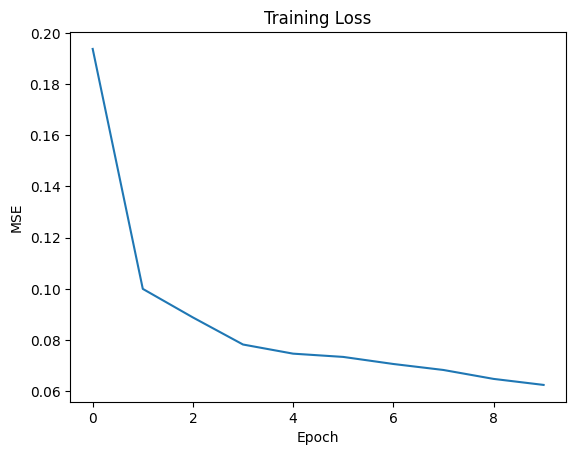

Accuracy: 94.89%


In [12]:
import numpy as np
import matplotlib.pyplot as plt

class FractionalNeuralNetwork:
    def __init__(self, input_size, learning_rate=1, power=0.5):
        # Network architecture parameters
        self.input_size = input_size  # Size of input layer (e.g., 784 for MNIST)
        self.eta = learning_rate     # Learning rate
        self.power = power           # Fractional power parameter (0 < power < 2)
        self.layers = []             # Layer configuration storage
        self.weights = []           # Weight matrices
        self.biases = []            # Bias vectors
        np.random.seed(0)           # For reproducibility

    def fracPower(self, value, power=None):
        """Applies fractional power while preserving sign"""
        power = power or self.power
        return np.sign(value) * np.abs(value)**power

    def dense(self, units, activation='sigmoid'):
        """Adds a dense layer with specified units"""
        # Determine input dimension based on previous layer
        input_dim = self.input_size if not self.layers else self.layers[-1]['units']

        # Store layer configuration and initialize weights/biases
        self.layers.append({'units': units, 'activation': activation})
        self.weights.append(np.random.randn(input_dim, units) * 0.1)  # Small random weights
        self.biases.append(np.zeros(units))                           # Zero initialized biases
        return self  # Allows method chaining

    # Activation functions
    def sigmoid(self, x): return 1/(1+np.exp(-x))
    def sigmoid_deriv(self, x): return self.sigmoid(x)*(1-self.sigmoid(x))

    def forward_pass(self, x):
        """Performs forward propagation through all layers"""
        self.activations = [x]  # Stores layer outputs
        self.z_values = []      # Stores pre-activation values

        for W, b, layer in zip(self.weights, self.biases, self.layers):
            z = np.dot(self.activations[-1], W) + b  # Linear transformation
            self.z_values.append(z)
            self.activations.append(self.sigmoid(z))  # Non-linear activation
        return self.activations[-1]  # Final output

    def backward_pass(self, x, target):
        """Performs backpropagation with fractional gradients"""
        error = target - self.activations[-1]

        # Apply fractional power to error and inputs
        frac_error = self.fracPower(error, 2-self.power)
        frac_inputs = self.fracPower(x, self.power)

        # Output layer gradient calculation
        delta = frac_error * self.sigmoid_deriv(self.z_values[-1])

        # Backpropagate through hidden layers
        deltas = [delta]
        for i in range(len(self.layers)-2, -1, -1):
            delta = np.dot(deltas[-1], self.weights[i+1].T) * self.sigmoid_deriv(self.z_values[i])
            deltas.append(delta)
        deltas.reverse()  # Reverse to match layer order

        # Update weights and biases
        for i in range(len(self.layers)):
            grad = np.outer(self.fracPower(self.activations[i], self.power),
                          self.fracPower(deltas[i], 2-self.power))
            self.weights[i] += self.eta * grad
            self.biases[i] += self.eta * deltas[i]

        return np.sum(error**2)  # Return MSE

    def train(self, X, y, epochs=10):
        """Trains the network for specified epochs"""
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0
            for xi, yi in zip(X, y):
                self.forward_pass(xi)
                epoch_loss += self.backward_pass(xi, yi)

            avg_loss = epoch_loss/len(X)
            losses.append(avg_loss)
            print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")

        # Plot training progress
        plt.plot(losses)
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.show()

    def predict(self, x):
        """Returns predicted class index"""
        return np.argmax(self.forward_pass(x))

    def evaluate(self, X_test, y_test):
        """Calculates and prints classification accuracy"""
        correct = sum(self.predict(xi) == np.argmax(yi) for xi, yi in zip(X_test, y_test))
        accuracy = correct/len(X_test)*100
        print(f"Accuracy: {accuracy:.2f}%")

# Example usage for MNIST
input_size = 784  # 28x28 images
output_size = 10   # Digits 0-9

# Create and train network
fnn = FractionalNeuralNetwork(input_size, power=0.8)
fnn.dense(64).dense(32).dense(output_size)  # 3-layer architecture
fnn.train(X_train, y_train, epochs=10)
fnn.evaluate(X_test, y_test)

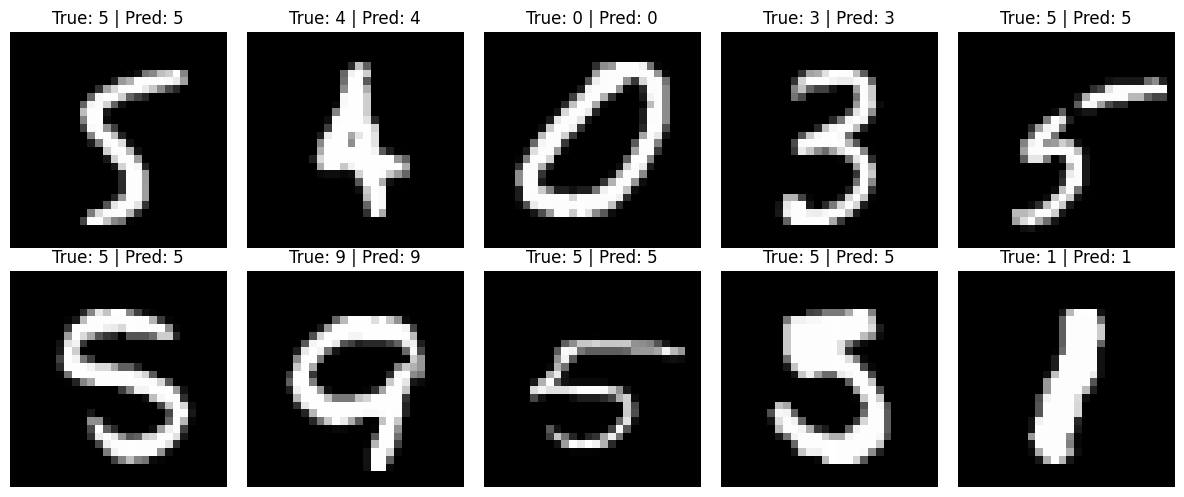

In [13]:
# --- Show a few examples with predictions ---
import random

num_examples = 10
indices = random.sample(range(len(X_test)), num_examples)

plt.figure(figsize=(12, 5))
for i, idx in enumerate(indices):
    image = X_test[idx].reshape(28, 28)
    true_label = np.argmax(y_test[idx])
    pred_label = fnn.predict(X_test[idx])

    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()